In [1]:
from pymongo import MongoClient
client = MongoClient()
db = client.whosampled
import numpy as np
import pandas as pd
import re
import implicit
import matplotlib.pyplot as plt
import random
import scipy.sparse as sparse

import sys
np.set_printoptions(threshold=sys.maxsize)

from src.turn_db_main_into_utility_matrix import from_mongo_collection_to_utility_matrix

In [2]:
#Get utility matrices and cleaned up df.

utility_to_song, utility_to_artist, df = from_mongo_collection_to_utility_matrix(db.main_redo)

Madlib is the producer with the most samples, with 1559 sampled.
James Brown is the most sampled artist, sampled 698 times.


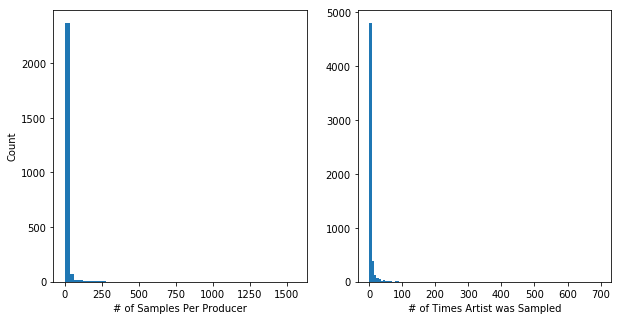

In [3]:
# Plot distributions of numbers of sampled, and max values.

producers = utility_to_artist.sum(axis =0)
sampled_artists = utility_to_artist.sum(axis =1)

prod_with_most_samples = utility_to_artist.sum(axis = 0).idxmax()
most_sampled_artist = utility_to_artist.sum(axis = 1).idxmax()
most_samples = utility_to_artist.sum(axis = 0).max()
times_sampled = utility_to_artist.sum(axis = 1).max()

print(
"{} is the producer with the most samples, with {} unique sampling instances.\n\
{} is the most sampled artist, sampled {} times.".format(
        prod_with_most_samples, most_samples, most_sampled_artist, times_sampled))

fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].set(xlabel = "# of Samples Per Producer", ylabel = "Count")
_ = ax[0].hist(producers, bins = 50)

# ax.annotate('local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )
ax[1].set(xlabel = "# of Times Artist was Sampled")
_ = ax[1].hist(sampled_artists, bins = 100)

In [4]:
# Top ten producers

utility_to_artist.sum(axis = 0).sort_values(ascending =False)\
.to_frame().rename(columns ={0:"Count"}).head(10)

,Count
new_song_producer,
Madlib,1559
9th Wonder,1122
The Alchemist,940
DJ Paul,930
DJ Premier,863
Juicy J,815
Kanye West,649
Knxwledge.,588
Prince Paul,558


In [5]:
# Top ten most sampled artists

utility_to_artist.sum(axis = 1).sort_values(ascending =False)\
.to_frame().rename(columns ={0:"Count"}).head(10)

#These results are shocking- Three 6 Mafia?

#I checked and they are right- three 6 gets sampled a lot.

,Count
sampled_artist,
James Brown,698
The Notorious B.I.G.,263
Three 6 Mafia,251
Public Enemy,245
Jay-Z,232
Kool & the Gang,200
Isaac Hayes,195
Michael Jackson,161
Run-DMC,154


In [6]:
# How sparse is matrix?
 
matrix_size = utility_to_artist.shape[0]*utility_to_artist.shape[1] # Number of possible interactions in the matrix
nonzeros = sum(utility_to_artist.sum(axis=0))
sparsity = 100*(1 - (nonzeros/matrix_size))
print([nonzeros, matrix_size, sparsity])

#We have a matrix that is 99.8% sparse. Kind of a problem. According to https://jessesw.com/Rec-System/ 
# maximum is 99.5%

#If we go by artist, we get down to 99.765%

[30540, 14018064, 99.78213824676503]



There are 15809 unique records. There are 1324 producers. There are 7789 songs sampled.

In [144]:
# May not use this cell.

from src.first_recommender_using_implict import get_model_and_user_items_from_utility_matrix
model, user_items_sparse = get_model_and_user_items_from_utility_matrix(utility_to_artist)

100%|██████████| 100.0/100 [00:06<00:00, 16.60it/s, loss=0.000813]


In [7]:
#What's up with Kanye?
print(utility_to_artist.loc["James Brown","Kanye West"])

#Actually, there is a 3 for Otis Redding- 
#is that because Kanye sampled him three times?

#An 11 for James Brown! Wow.

sum(utility_to_song.loc[:,"Kanye West"])
#Apparently he sampled 640 artists, also 640 songs.

11


649

In [8]:
utility_to_artist.head()

new_song_producer,"""Buttnaked"" Tim Dawg",$uicideboy$,10,12 Finger Dan,12 Million,138th,14Kt,1500 or Nothin',2 in Rhythm,21 Savage,...,Zavala,Zaytoven,Zen Zan,Zero 7,Zukhan Bey,d.r.u.g.s.,hAZEL,i.V.,nineteen85,will.i.am
sampled_artist,,,,,,,,,,,,,,,,,,,,,
"""Sweet"" Charles Sherrell",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'Lee' George Quinones,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
*NSYNC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1 Life 2 Live,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Make train set.
# First, we do in the most basic way: Set twenty percent of actual 
#interactions to non-interactions. Don't do it by row, just entire dataframe.

#transpose matrix, because he has users as columns (which certainly makes more sense.)
utility_to_artist_sparse = sparse.csr_matrix(utility_to_artist.T)

from src.make_train_set import make_train

train_set, test_set, user_rows_altered = make_train(utility_to_artist_sparse, 0.01)

In [11]:
#Settings from https://jessesw.com/Rec-System/
# He says these are best
#However the method is deprecated- I can use the recommendations thing instead but no alpha
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((train_set*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)

This method is deprecated. Please use the AlternatingLeastSquares class instead
100%|██████████| 50.0/50 [00:08<00:00,  6.09it/s]


In [15]:
from src.auc_testing import auc_score, calc_mean_auc

calc_mean_auc(train_set, user_rows_altered, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], test_set)

(0.752, 0.851)

In [19]:
# Record of scores
train_set = [0.5, 0.3, 0.2, 0.1, 0.05, 0.01, 0.005, .001, 0.0005]
alpha = 15

def test_different_train_test_split(split, alpha):
    
    '''
    This function splits data using make_train, 
    Trains a new model on the data and makes predictions using implicit library.
    Calculates mean_auc of the model as well as the mean_auc of popularity alone. 
    Input: A train_test split, alpha value.
    
    '''
    train_set, test_set, user_rows_altered = make_train(utility_to_artist_sparse, split)
    user_vecs, item_vecs = implicit.alternating_least_squares((train_set*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)
    return calc_mean_auc(train_set, user_rows_altered, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], test_set)
    
scores = [test_different_train_test_split(split, alpha) for split in train_set]

100%|██████████| 50.0/50 [00:03<00:00, 12.80it/s]
100%|██████████| 50.0/50 [00:05<00:00,  9.27it/s]
100%|██████████| 50.0/50 [00:08<00:00,  9.58it/s]
100%|██████████| 50.0/50 [00:05<00:00, 10.28it/s]
100%|██████████| 50.0/50 [00:08<00:00,  5.74it/s]
100%|██████████| 50.0/50 [00:05<00:00, 11.13it/s]
100%|██████████| 50.0/50 [00:10<00:00,  4.95it/s]
100%|██████████| 50.0/50 [00:06<00:00,  8.03it/s]
100%|██████████| 50.0/50 [00:09<00:00,  5.43it/s]


In [20]:
scores

[(0.603, 0.843),
 (0.667, 0.841),
 (0.691, 0.838),
 (0.726, 0.844),
 (0.734, 0.851),
 (0.76, 0.851),
 (0.757, 0.867),
 (0.775, 0.808),
 (0.547, 0.8)]

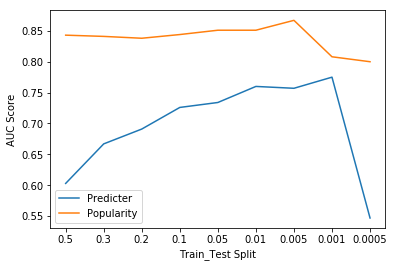

In [38]:
fig, ax = plt.subplots()
plt.xticks(np.arange(0, 9, 1), train_set)

#Plot Predicter versus Popularity alone. 

for num, label in zip(range(2), ["Predicter", "Popularity"]):
    ax.plot([i[num] for i in scores], label = label)

ax.set(xlabel = "Train_Test Split", ylabel = "AUC Score")
_ = ax.legend(loc = 'best')
    

([<matplotlib.axis.XTick at 0x126aa1c88>,
 <a list of 8 Text xticklabel objects>)

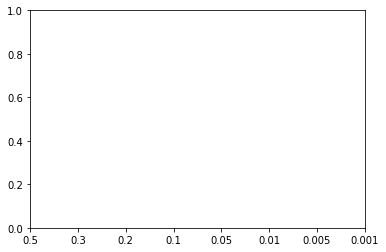

In [29]:
ax.legend()